In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

# Kiểm tra có mount được đến thư mục chứa data hay không?
os.chdir("/content/drive/My Drive/LTSS/Me/Final")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'21 01-Report.ipynb'	      v2_device_seam_energy.txt
 in.pnm			      v2_device_seam.pnm
 v1_host_out.pnm	      v2_seamCarving
 v1_host_pixel_energy.txt     v2_seamCarving.cu
 v1_host_seam_energy.txt      v3_device_out.pnm
 v1_host_seam.pnm	      v3_device_pixel_energy.txt
 v1_seamCarving		      v3_device_seam_energy.txt
 v1_seamCarving.cu	      v3_seamCarving
 v2_device_out.pnm	      v3_seamCarving.cu
 v2_device_pixel_energy.txt


In [ ]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  print("Image size (width x height): {} x {}".format(w, h))
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

# ĐỒ ÁN CUỐI KỲ MÔN "LẬP TRÌNH SONG SONG"
### GVHD: TRẦN TRUNG KIÊN
### THỰC HIỆN: Nhóm 11
### DANH SÁCH THÀNH VIÊN
 1. 18120579 - ĐẶNG MINH THỌ
 2. 10120584 - PHẠM ĐÌNH THỤC

Link kế hoạch làm việc nhóm: https://docs.google.com/spreadsheets/d/1ut2bqyMlK3yd02dfPk-1-aYlFGSHFWV332MrNUD2DmQ/edit#gid=0

# 1. MÔ TẢ ỨNG DỤNG

- **Ứng dụng nhóm chọn**: Seam Carving
  - *Seam Carving* là một thuật toán để thay đổi kích thước hình ảnh.
  -  Mục đích của thuật toán là thay đổi kích thước hình ảnh mà các đối tượng chính trong hình ảnh không bị biến dạng
- **Input**: một tấm ảnh (đồ án này: ảnh RGB)
- **Output**: tấm ảnh được thay đổi kích thước mà không làm biến dạng các đối tượng quan trọng (đồ án này: tấm ảnh được thu hẹp chiều rộng lại)
- **Ý nghĩa thực tế của ứng dụng**: 
  - Một use case là ta có thể muốn có các phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển thị trên các thiết bị khác nhau (máy tính, điện thoại, ...)
  - Ngoài ra, ứng dụng có thể được áp dụng vào các app chỉnh sửa ảnh.
- **Ứng dụng này có cần tăng tốc không?**
  - Cần, ứng dụng này chạy chậm khi cài đặt tuần tự

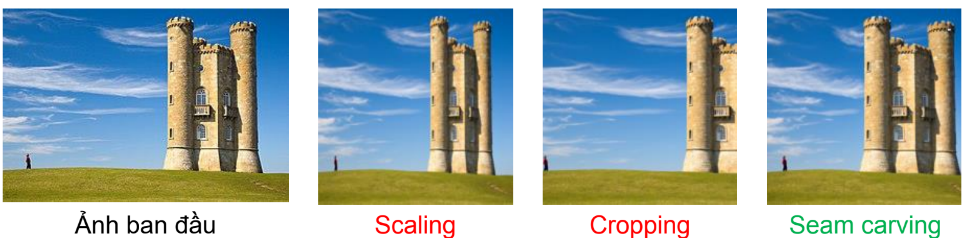

*Nguồn ảnh: Trang 16 Slide 15-DoAnCK.pdf*

# 2. CÀI ĐẶT TUẦN TỰ

## 2.1 THIẾT KẾ
*(chú thích: Energy - độ quan trọng)*
- Yêu cầu: Thu hẹp chiều rộng ảnh
- **Input**: ảnh RGB 
- Đọc ảnh đầu vào 
- Chuyển ảnh đầu vào sang ảnh grayscale

**Bước 1: Dùng edge detection để tính độ quan trọng của mỗi pixel**
  - Thực hiện *convolution* giữa ảnh grayscale với bộ lọc x-Sobel *(1)*
$$\begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$
  - Thực hiện *convolution* giữa ảnh grayscale với bộ lọc y-Sobel *(2)*
$$\begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$
  - Tính độ quan trọng của một pixel 
```
 Energy của một pixel = |kết quả (1)| + |kết quả (2)|
```

**Bước 2: Tính độ quan trọng của mỗi Seam**
```
 Energy của seam = Energy của pixel hiện tại + Min (Energy của seam liền kề bên dưới được kết nối)
```
  - Trong đó: các pixel liền kề bên dưới được kết nối lần lượt là các pixel ở vị trí left, mid và right.

**Bước 3: Tìm seam có ít độ quan trọng nhất từ độ quan trọng của các seam**
- Duyệt dãy các phần tử đầu tiên để tìm ra phần tử có giá trị nhỏ nhất chứa độ quan trọng của seam.
- Dựa vào các giá trị của mảng next_pixels (mảng chứa các vị trí của các pixel kế tiếp của các seam)

**Bước 4: Xóa Seam có ít độ quan trọng nhất vừa tìm được** 
- Tính toán vị trí của điểm ảnh hiện tại sẽ trở thành vị trí nào sau khi xóa seam có độ quan trọng ít nhất. Sau đó gán điểm ảnh hiện tại vào vị trí đã được tính toán
Ghi ảnh đầu ra

**Output**: Ảnh đã xóa 1 seam (có nghĩa là giảm 1 pixel theo chiều ngang)

Tiến hành lặp lại quá trình cho đến khi đạt được chiều rộng phù hợp.
  


## 2.2 ĐÁNH GIÁ
- Kịch bản thí nghiệm : Thí nghiệm trên ảnh 640 x 434 với kích thước thay đổi là 100 (tức là giảm 100 pixel theo chiều ngang).

In [ ]:
!nvcc v1_seamCarving.cu -o v1_seamCarving --disable-warnings

In [ ]:
!./v1_seamCarving in.pnm host 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Host time: 
5005.936035 ms


Image size (width x height): 541 x 434


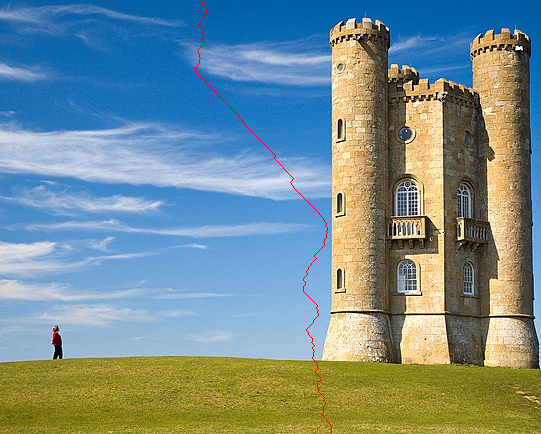

In [ ]:
show_pnm('v1_host_seam.pnm')

Image size (width x height): 540 x 434


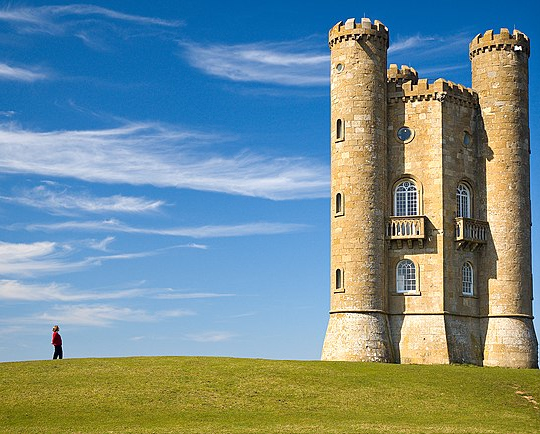

In [ ]:
show_pnm('v1_host_out.pnm')

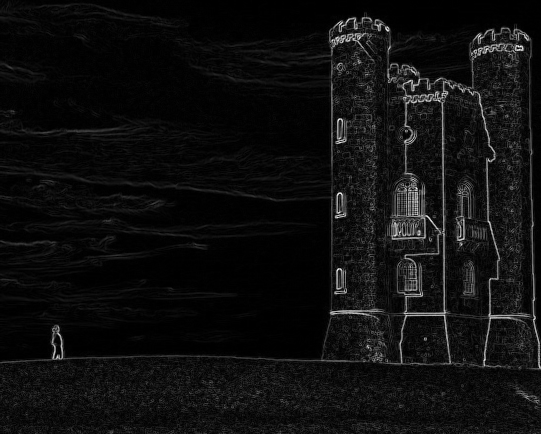

In [ ]:
show_matrix('v1_host_pixel_energy.txt')

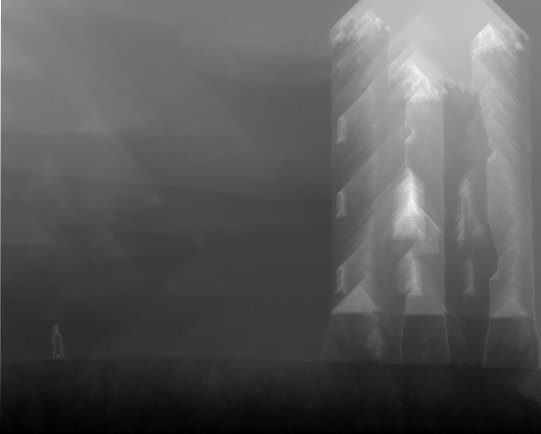

In [ ]:
show_matrix('v1_host_seam_energy.txt')

# 3. CÀI ĐẶT SONG SONG

## 3.1 PHÂN TÍCH
Các bước cần song song hóa: Bước 1, 2, 4 ở phiên bản cài đặt tuần tự.


*   Bước 1: Tính độ quan trọng của mỗi pixel.
*   Bước 2: Tính độ quan trọng các seam bằng độ quan trọng của các pixel.
*   Bước 4: Xóa seam có ít độ quan trọng nhất.



## 3.2 THIẾT KẾ
* **Bước 1** : Tham khảo từ bài làm mờ ảnh ở HW3, mỗi thread được phân để tính giá trị cho một điểm ảnh, điểm khác biệt là filter lúc này bao gồm cả 2 filter **x-Sobel** và filter **y-Sobel** và kết quả lả tổng trị tuyệt đối các giá trị tính được sau khi tính tích chập (convolution) từ 2 filter này với ảnh đầu vào.
* **Bước 2** : Thực hiện tính độ quan trọng của các seam tính từ dưới cùng bằng cách chạy vòng lặp với mỗi vòng lặp thì mỗi thread sẽ được phân bố để tính độ quan trọng cho 1 điểm ảnh.
* **Bước 4** : Mỗi thread sẽ xử lý một điểm ảnh. Dựa vào mảng seam tính được, tính toán vị trí của điểm ảnh hiện tại sẽ trở thành vị trí nào sau khi xóa seam có độ quan trọng ít nhất. Sau đó gán điểm ảnh hiện tại vào vị trí đã được tính toán.

## 3.3 ĐÁNH GIÁ
- Kịch bản thí nghiệm : Thí nghiệm trên ảnh 640 x 434 với kích thước thay đổi là 100 (tức là giảm 100 pixel theo chiều ngang).

In [ ]:
!nvcc v2_seamCarving.cu -o v2_seamCarving --disable-warnings

In [ ]:
!./v2_seamCarving in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
364.205414 ms


Image size (width x height): 541 x 434


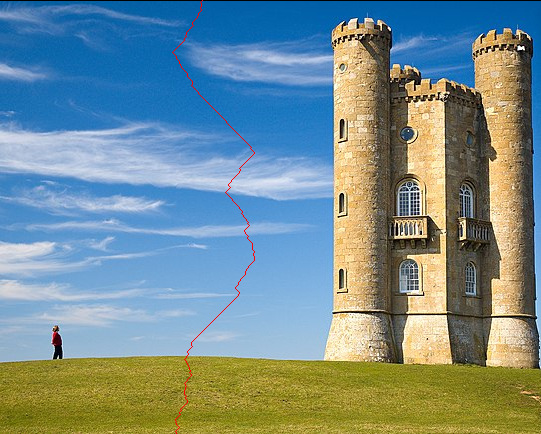

In [ ]:
show_pnm('v2_device_seam.pnm')

Image size (width x height): 540 x 434


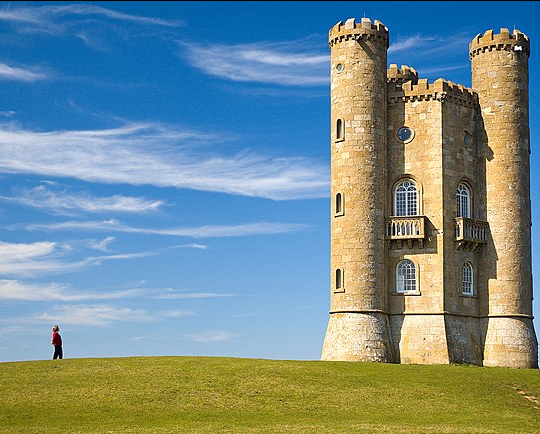

In [ ]:
show_pnm('v2_device_out.pnm')

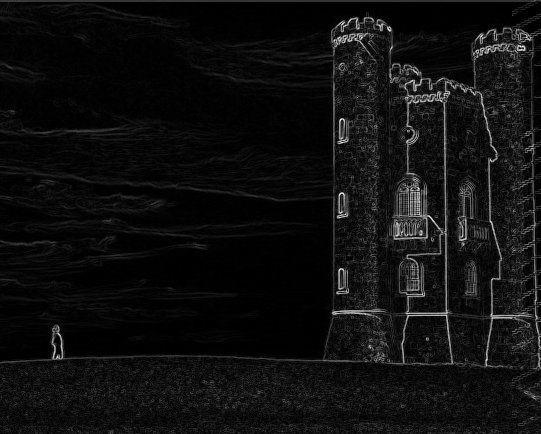

In [ ]:
show_matrix('v2_device_pixel_energy.txt')

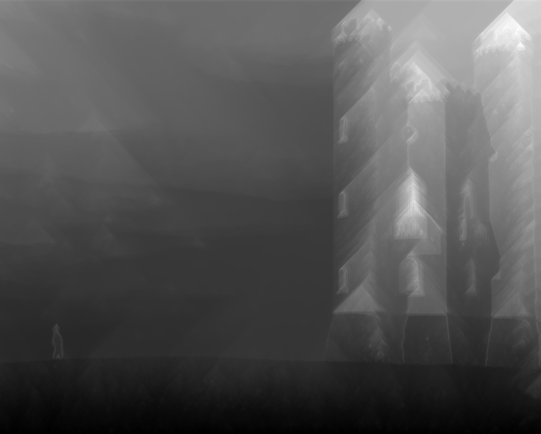

In [ ]:
show_matrix('v2_device_seam_energy.txt')

# 4. CÀI ĐẶT SONG SONG + TỐI ƯU HÓA

## 4.1 PHÂN TÍCH
Các bước được tối ưu hóa:
- **Bước 2**: Tính toán độ quan trọng các pixel bằng edgeDetection. Hàm kernel thực hiện phép edgeDetection (Bước 2). Dữ liệu ảnh được lưu ở GMEM nên thời gian truy xuất chậm. Ta cần cải thiện bước này.

- **Bước 4**: Xóa seam có ít độ quan trọng nhất. Hàm kernel thực hiện xóa các điểm ảnh thuộc seam (Bước 4) được tối ưu vì thuật toán ban đầu là mỗi pixels phải duyệt qua từng phần tử trong mảng seam để xác định được vị trí sau khi xóa seam cho nên cần được tối ưu để giảm số lần duyệt seam lại hoặc chỉ duyệt một lần duy nhất.



## 4.2 THIẾT KẾ
- **Bước 2**: Ta sẽ đưa dữ liệu ảnh đã được xử lý vào SMEM với mục đích ta sẽ giảm thời gian truy xuất dữ liệu từ SM đến GMEM. Mỗi block sẽ đọc dữ liệu từ inPixels ở GMEM vào SMEM, sau đó dữ liệu ở SMEM này sẽ được dùng lại nhiều lần cho các thread trong block.

- **Bước 4**: Thay vì tính toán vị trí của tất cả điểm ảnh hiện tại. Ta sẽ tính  vị trí các điểm ảnh thực sự thay đổi sau khi xóa seam. Các vị trí thực sự thay đổi này sẽ nằm về 1 bên so với seam được xóa. Các vị trí ở phía còn lại của seam sẽ được giữ nguyên. 

## 4.3 ĐÁNH GIÁ
- Kịch bản thí nghiệm : Thí nghiệm trên ảnh 640 x 434 với kích thước thay đổi là 100 (tức là giảm 100 pixel theo chiều ngang).

In [ ]:
!nvcc v3_seamCarving.cu -o v3_seamCarving --disable-warnings

In [ ]:
!./v3_seamCarving in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
218.851654 ms


Image size (width x height): 540 x 434


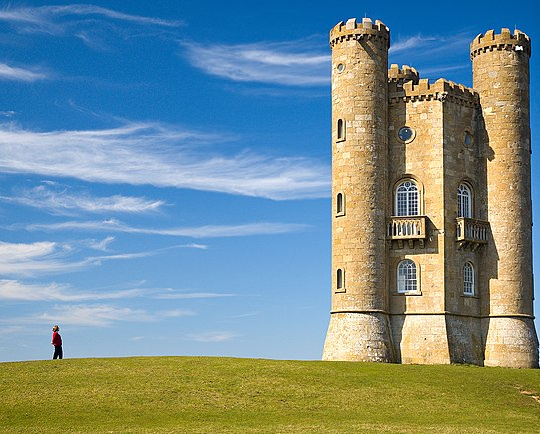

In [ ]:
show_pnm('v3_device_out.pnm')

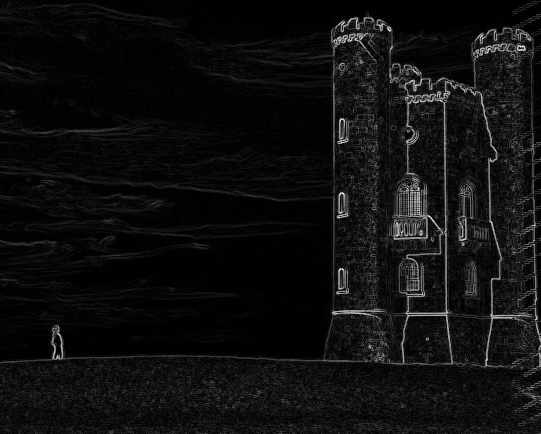

In [ ]:
show_matrix('v3_device_pixel_energy.txt')

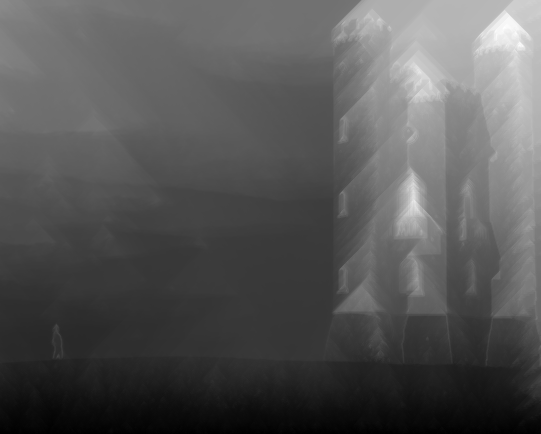

In [ ]:
show_matrix('v3_device_seam_energy.txt')

# 5. TỔNG KẾT

| <font size="5"> Phiên bản </font>|<font size="5"> Thời gian </font>|
|:-------------------:|-----------------------:|
|<font size="4"> Version 1 host (sequentially)</font>   | <font size="3"> ~5000 ms</font>  
| <font size="4"> Version 2 kernel (parallel)</font> | <font size="3"> ~ 400 ms</font>         |
| <font size="4"> Version 3 kernel (parallel + optimization)</font> |    <font size="3"> ~ 250 ms  </font>         |     <font size="3">  0.65634  </font>       |

# 6. NHÌN LẠI QUÁ TRÌNH LÀM ĐỒ ÁN

#### **Đặng Minh Thọ**
- **Thuận lợi**: Có thể tham khảo trên Internet dễ dàng. 
- **Khó khăn**: Chưa thể tìm hiểu kiến thức chuyên sâu. Do đồ án được thực hiện dịp gần Tết và thời gian thi cuối cuối kì nên em cũng gặp một vài khó khăn 
- Qua đồ án này em học được các kiến thức: Biết thêm về thuật toán Seam Carving. Cách tối ưu hóa thuật toán


#### **Phạm Đình Thục**
- **Thuận lợi**: Có nhiều nguồn tài liệu tham khảo. Bài toán đã được nhiều người giải quyết trước đó. 
- **Khó khăn**: Các kiến thức chuyên sâu còn chưa nắm kĩ nên gặp khó khăn trong quá trình tìm hiểu và thực hiện đồ án. Đồ án được thực hiện trong thời điểm thi các môn cuối kỳ nên gặp khó khăn trong việc phân chia thời gian học và thi.
- Qua đồ án này em học được các kiến thức: Kiến thức về thuật toán Seam Carving. Các kiến thức về tối ưu các kernel nhằm làm tăng tốc độ của thuật toán 


#### **Cải thiện bài toán**
Ứng dụng việc thay đổi kích thước ảnh bằng cách sử dụng "Seam Carving" ít nhiều khi thực hiện lượt bỏ đi một số lượng đáng kể nhiều seam thì ảnh bị bóp mèo là không tránh khỏi. 

Nhóm sẽ tìm hiểu để sau khi thực hiện việc thay đổi kích thước này ảnh sẽ mất mát dữ liệu là ít nhất

# 7. TÀI LIỆU THAM KHẢO

*   15-DoAnCK.pdf từ thùng chứa tài liệu học tập
*   Seam carving: https://en.wikipedia.org/wiki/Seam_carving
*   Seam Carving Algorithm: https://vnoi.info/wiki/cs/imageprocessing/Seam-Carving.mdfbclid=IwAR1VcBNPXMgACkelcRPZqVcxtb1SBM3UPAXuScN7JiZ_dsaJ3DmSw2vcL_I
*   Youtube (Seam Carving): https://www.youtube.com/watch?v=-YfbEd_48uY&ab_channel=NathanDileas
*   Seam Carving | Week 2 | 18.S191 MIT Fall 2020 | Grant Sanderson: https://www.youtube.com/watch?v=rpB6zQNsbQU&ab_channel=TheJuliaProgrammingLanguage
*   Stackoverflow: https://stackoverflow.com/

